In [1]:
#For importing modules
import sys


# final pre-processing
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from tensorflow.keras.utils import Sequence
import numpy as np


# model
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, BatchNormalization

# evaluation
from sklearn.metrics import precision_score, recall_score, confusion_matrix,classification_report,roc_curve, roc_auc_score
import matplotlib.pyplot as plt


In [2]:
sys.path.append('/path/to/2014_07_13_test')
import generate_input

## Load data

In [3]:
# # filter small cases
# filter_case = ['case_00018', 'case_00031', 'case_00042', 'case_00056', 'case_00088', 'case_00090', 'case_00092', 
#                'case_00106', 'case_00120', 'case_00133', 'case_00183', 'case_00200', 'case_00211', 'case_00228',
#                'case_00234', 'case_00237', 'case_00249', 'case_00277', 'case_00288', 'case_00291']

In [4]:
# load validation set
val_case = ['case_00233', 'case_00089', 'case_00050', 'case_00112', 'case_00258', 'case_00246', 'case_00157',
            'case_00149','case_00184']
test_case = ['case_00221', 'case_00259', 'case_00087', 'case_00254', 'case_00098', 'case_00023', 'case_00041',
             'case_00080', 'case_00101', 'case_00164', 'case_00002', 'case_00110', 'case_00030', 'case_00068',
             'case_00026', 'case_00063', 'case_00006', 'case_00048', 'case_00250', 'case_00238',
             'case_00111', 'case_00278', 'case_00133', 'case_00284', 'case_00282', 'case_00269', 'case_00039',
             'case_00033', 'case_00108', 'case_00175', 'case_00161', 'case_00256', 'case_00119', 'case_00286',
             'case_00077', 'case_00162', 'case_00270', 'case_00271', 'case_00285', 'case_00174', 'case_00147',
             'case_00215', 'case_00150', 'case_00052', 'case_00231', 'case_00198', 'case_00117', 'case_00138',
             'case_00211', 'case_00190', 'case_00248', 'case_00235', 'case_00049', 'case_00074', 'case_00107',
             'case_00218', 'case_00001', 'case_00193', 'case_00067', 'case_00072', 'case_00044',
             'case_00294', 'case_00298', 'case_00263', 'case_00038', 'case_00299', 'case_00249', 'case_00225',
             'case_00217', 'case_00178', 'case_00082', 'case_00035', 'case_00034', 'case_00047', 'case_00276',
             'case_00151', 'case_00226', 'case_00086', 'case_00176']

In [5]:
all_cases = [ 'case_' + str(number).zfill(5) for number in range(300)] # create list of all cases
train_case = [x for x in all_cases if x not in val_case and x not in test_case] # take only cases not in test and val

In [5]:
def generate_part_label_dict(labels_dict, list_of_cases):
    return {k: labels_dict[k] for k in list_of_cases}

def load_data(rootdir, img_dir, json_path, list_cases, isLabels = False):
    val_path = generate_input.processed_image_paths(rootdir, img_dir)
    labels_dict = generate_input.malignant_labels_to_dict(json_path)
    labels_dict_short = generate_part_label_dict(labels_dict, list_cases)
    image_dict_short = generate_input.load_nifti_img_and_mask_as_numpy(val_path, list_cases)
    x_set, y_set, labels_val = generate_input.fill_set(list_cases, labels_dict_short, image_dict_short, labels_dict, True)
    
    x_set = generate_input.adding_channel(x_set)
    if isLabels == True:
        return x_set, y_set, labels_val
    else:
        return x_set, y_set

In [6]:
x_val, y_val, labels_val = load_data('./cropped-data/', 'images-64', '../kits21/kits21/data/kits.json', val_case, True)
x_test, y_test, labels_test = load_data('./cropped-data/', 'images-64', '../kits21/kits21/data/kits.json', test_case, True)

In [7]:
x_train, y_train = load_data('./cropped-data/', 'images-64', '../kits21/kits21/data/kits.json', train_case)

NameError: name 'train_case' is not defined

In [ ]:
# x_train, y_train, x_val, y_val, x_test, y_test, id_val, id_test = generate_input.generate_data_input(
#     '../kits21/kits21/data/kits.json', n_samples = 300, neg_pct = 100, rootdir = './preprocessed-data/', 
#     img_dir = 'images', mask_dir = 'masks', val_split = 9, test_split = 81)

In [8]:
x_train_mask, y_train_mask = load_data('./cropped-data/', 'masks-64', '../kits21/kits21/data/kits.json', train_case)
x_test_mask, y_test_mask, labels_test = load_data('./cropped-data/', 'masks-64', '../kits21/kits21/data/kits.json', test_case, True)
x_val_mask, y_val_mask, labels_val = load_data('./cropped-data/', 'masks-64', '../kits21/kits21/data/kits.json', val_case, True)

In [9]:
print(x_train_mask.shape, x_train.shape, len(y_train))
print(x_val_mask.shape, x_val.shape, len(y_val))
print(x_test_mask.shape, x_test.shape, len(y_test))

(1152, 64, 64, 3) (1152, 64, 64, 3) 1152
(10112, 64, 64, 3) (10112, 64, 64, 3) 10112


In [10]:
def empty_image_removal(masks, images, labels):
    x_final = []
    y_final = []

    for i, pair in enumerate(zip(masks, images, labels)):
    
        if len(np.unique(pair[0])) > 1:
            x_final.append(pair[1])
            y_final.append(pair[2])
            
    x_final = np.array(x_final)
    y_final = np.array(y_final)
    return x_final, y_final

In [11]:
x_val_final, y_val_final = empty_image_removal(x_val_mask, x_val, y_val)
x_train_final, y_train_final = empty_image_removal(x_train_mask, x_train, y_train)
x_test_final, y_test_final = empty_image_removal(x_test_mask, x_test, y_test)

In [12]:
print(x_val_final.shape, y_val_final.shape)
print(x_train_final.shape, y_train_final.shape)
print(x_test_final.shape, y_test_final.shape)

(530, 64, 64, 3) (530, 1)
(4456, 64, 64, 3) (4456, 1)


## Upsampling 

In [15]:
x_train_reshape = x_train_final.reshape(x_train_final.shape[0], x_train_final.shape[1] * x_train_final.shape[2] * x_train_final.shape[3])
sm = SMOTE(random_state=64)
x_smote, y_smote = sm.fit_resample(x_train_reshape, y_train_final)
x_smote = x_smote.reshape(x_smote.shape[0], x_train_final.shape[1], x_train_final.shape[2], x_train_final.shape[3])

In [16]:
x_smote, y_smote = shuffle(x_smote, y_smote)

In [17]:
print(len(x_smote), len(y_smote))

22134 22134


## Developing baseline model

In [18]:
# a code is taken from https://stackoverflow.com/questions/62916904/failed-copying-input-tensor-from-cpu-to-gpu-in-order-to-run-gatherve-dst-tensor
batch_size = 16
class DataGenerator(Sequence):
    """ Send data to the model using TF in specified sizes of batch """
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(x_smote, y_smote, batch_size)

In [61]:
# draft model
#inputs = Input(shape=(224, 224, 3))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=2)

resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(64,64,3))

# for layer in resnet.layers:
#     layer.trainable = True

layer_name = "conv4_block6_out"
metrics_list = [tf.keras.metrics.AUC(name = 'auc'),
                tf.keras.metrics.BinaryAccuracy(name = 'accuracy')]

#calculate class weights
class_weights = {0 : 47, 1 : 1} 
# 40 is not good 

optimizer_fn = tf.keras.optimizers.experimental.RMSprop(learning_rate=0.001, jit_compile = False)
#optimizer_fn = tf.keras.optimizers.Adam(learning_rate=0.0001)

intermediate_model = tf.keras.Model(inputs=resnet.input, outputs=resnet.get_layer(layer_name).output)
x = Flatten()(intermediate_model.output) 
x = Dense(1024, activation = 'relu')(x) #kernel_regularizer = 'l1'
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation = 'relu', kernel_regularizer = 'l2')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(64, activation = 'relu')(x)

x = Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(intermediate_model.input, x)

model.compile(optimizer = optimizer_fn, loss='binary_crossentropy', metrics= metrics_list)
model.summary()
history=model.fit(train_gen, validation_data = (x_val_final, y_val_final), epochs=5, batch_size = batch_size, class_weight = class_weights)


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 16, 16, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 16, 16, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 16, 16, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 8, 8, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 8, 8, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 4, 4, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

2023-05-12 11:33:04.376383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1384/1384 [==============================] - ETA: 0s - loss: 1.6149 - auc: 0.9649 - accuracy: 0.8333

2023-05-12 11:39:12.212542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1384/1384 [==============================] - 378s 261ms/step - loss: 1.6149 - auc: 0.9649 - accuracy: 0.8333 - val_loss: 0.3342 - val_auc: 0.7914 - val_accuracy: 0.8509
Epoch 2/5
1384/1384 [==============================] - 330s 238ms/step - loss: 0.5317 - auc: 0.9927 - accuracy: 0.9611 - val_loss: 0.4400 - val_auc: 0.5228 - val_accuracy: 0.9038
Epoch 3/5
1384/1384 [==============================] - 332s 240ms/step - loss: 0.3533 - auc: 0.9956 - accuracy: 0.9844 - val_loss: 0.2997 - val_auc: 0.9264 - val_accuracy: 0.8906
Epoch 4/5
1384/1384 [==============================] - 334s 241ms/step - loss: 0.2731 - auc: 0.9966 - accuracy: 0.9876 - val_loss: 0.2448 - val_auc: 0.9522 - val_accuracy: 0.9245
Epoch 5/5
1384/1384 [==============================] - 342s 247ms/step - loss: 0.3910 - auc: 0.9952 - accuracy: 0.9859 - val_loss: 0.4588 - val_auc: 0.7997 - val_accuracy: 0.8340


In [62]:
print("number of epochs:", len(history.history['loss']))

number of epochs: 5


## Loss

In [63]:
# #plot the training and validation IoU and loss at each epoch
# loss = history.history['loss']

# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [64]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# plt.plot(epochs, acc, 'y', label='Training accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

## Evaluation of validation test

In [31]:
results = loaded_model.evaluate(x_val_final, y_val_final)
results

17/17 [==============================] - 0s 22ms/step - loss: 0.7582 - auc: 0.8619 - accuracy: 0.8151


[0.75819331407547, 0.8618770241737366, 0.8150943517684937]

In [32]:
y_pred = loaded_model.predict(x_val_final)

17/17 [==============================] - 1s 54ms/step


In [33]:
precision = precision_score(y_val_final, y_pred.round()) 
recall = recall_score(y_val_final, y_pred.round())
print(precision)
print(recall)

0.9925187032418953
0.8073022312373225


In [34]:
confusion_matrix(y_val_final, y_pred.round())

array([[ 34,   3],
       [ 95, 398]])

In [35]:
print(classification_report(y_val_final, y_pred.round(), digits = 4)) 

              precision    recall  f1-score   support

         0.0     0.2636    0.9189    0.4096        37
         1.0     0.9925    0.8073    0.8904       493

    accuracy                         0.8151       530
   macro avg     0.6280    0.8631    0.6500       530
weighted avg     0.9416    0.8151    0.8568       530



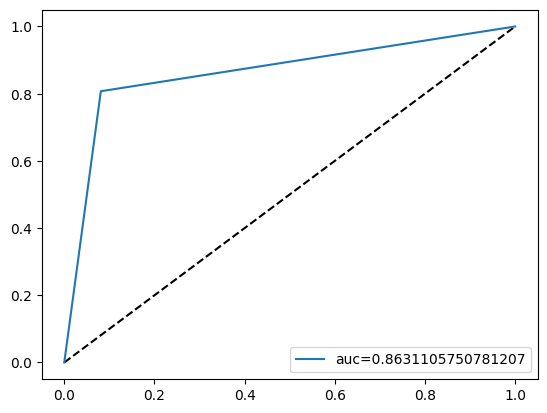

In [36]:
fpr, tpr, _ = roc_curve(y_val_final,  y_pred.round())
auc = roc_auc_score(y_val_final, y_pred.round())
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Evaluation of test set

In [41]:
y_pred_test = loaded_model.predict(x_test_final)

140/140 [==============================] - 2s 12ms/step


In [42]:
confusion_matrix(y_test_final, y_pred_test.round())

array([[  65,  179],
       [ 599, 3613]])

In [43]:
print(classification_report(y_test_final, y_pred_test.round(), digits = 4))

              precision    recall  f1-score   support

         0.0     0.0979    0.2664    0.1432       244
         1.0     0.9528    0.8578    0.9028      4212

    accuracy                         0.8254      4456
   macro avg     0.5253    0.5621    0.5230      4456
weighted avg     0.9060    0.8254    0.8612      4456



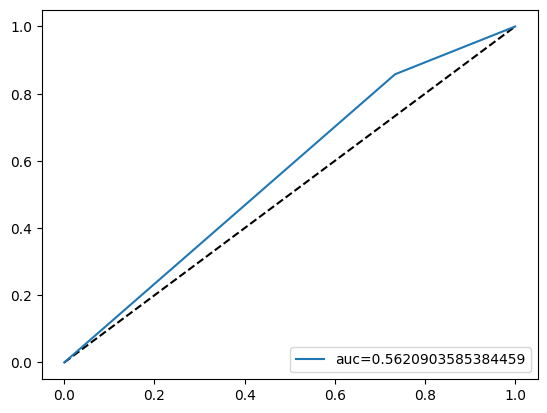

In [40]:
fpr, tpr, _ = roc_curve(y_test_final,  y_pred_test.round())
auc = roc_auc_score(y_test_final, y_pred_test.round())
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Save model

In [76]:
# model_json = model.to_json()
# with open("model64croped_segmented5.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model64croped_segmented5.h5")

## Load model

In [13]:
# load json and create model
json_file = open('model64croped_segmented3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model64croped_segmented3.h5")

2023-05-12 14:49:05.065588: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-12 14:49:05.065741: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro


In [14]:
# evaluate loaded model on test data
optimizer_fn = tf.keras.optimizers.experimental.RMSprop(learning_rate=0.001, jit_compile = False)
metrics_list = [tf.keras.metrics.AUC(name = 'auc'),
                tf.keras.metrics.BinaryAccuracy(name = 'accuracy')]
loaded_model.compile(optimizer = optimizer_fn, loss='binary_crossentropy', metrics= metrics_list)
score1 = loaded_model.evaluate(x_val_final, y_val_final)
score1

2023-05-12 14:49:05.821570: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-12 14:49:06.088951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 38ms/step - loss: 0.7582 - auc: 0.8619 - accuracy: 0.8151


[0.75819331407547, 0.8618770241737366, 0.8150943517684937]

## Majority voting

In [15]:
# load validation set
val_case = ['case_00233', 'case_00089', 'case_00050', 'case_00112', 'case_00258', 'case_00246', 'case_00157', 'case_00149','case_00184']
test_case = ['case_00221', 'case_00259', 'case_00087', 'case_00254', 'case_00098', 'case_00023', 'case_00041',
             'case_00080', 'case_00101', 'case_00164', 'case_00002', 'case_00110', 'case_00030', 'case_00068',
             'case_00026', 'case_00063', 'case_00006', 'case_00048', 'case_00250', 'case_00238',
             'case_00111', 'case_00278', 'case_00133', 'case_00284', 'case_00282', 'case_00269', 'case_00039',
             'case_00033', 'case_00108', 'case_00175', 'case_00161', 'case_00256', 'case_00119', 'case_00286',
             'case_00077', 'case_00162', 'case_00270', 'case_00271', 'case_00285', 'case_00174', 'case_00147',
             'case_00215', 'case_00150', 'case_00052', 'case_00231', 'case_00198', 'case_00117', 'case_00138',
             'case_00211', 'case_00190', 'case_00248', 'case_00235', 'case_00049', 'case_00074', 'case_00107',
             'case_00218', 'case_00001', 'case_00193', 'case_00067', 'case_00072', 'case_00044',
             'case_00294', 'case_00298', 'case_00263', 'case_00038', 'case_00299', 'case_00249', 'case_00225',
             'case_00217', 'case_00178', 'case_00082', 'case_00035', 'case_00034', 'case_00047', 'case_00276',
             'case_00151', 'case_00226', 'case_00086', 'case_00176']

In [16]:
def adding_channel_dict(image_dict):
    """Convert from one channel to three channel images that are stored in dictionary """
    for key in image_dict:
        image_dict[key] = generate_input.adding_channel(image_dict[key])
    return image_dict


def empty_image_removal_dict(masks, images):
    """removes images with 0 padding"""
    x_final_dict = {}
    
    common_keys = masks.keys() & images.keys()
    for key in common_keys:
        x_final = []

        for i, pair in enumerate(zip(masks[key], images[key])):
    
            if len(np.unique(pair[0])) > 1:
                x_final.append(pair[1])
            
        x_final = np.array(x_final)

        
        x_final_dict[key] = x_final
    return x_final_dict

def load_data_to_evaluate_by_majority_voting(rootdir, img_dir, json_path, list_cases):
    """ Load images and labels in dictionary format """
    val_path = generate_input.processed_image_paths(rootdir, img_dir)
    labels_dict = generate_input.malignant_labels_to_dict(json_path)
    labels_dict_short = generate_part_label_dict(labels_dict, list_cases)
    labels_dict_short = {key: float(value) for key, value in labels_dict_short.items()}
    
    image_dict_short = generate_input.load_nifti_img_and_mask_as_numpy(val_path, list_cases)
    image_dict_short = adding_channel_dict(image_dict_short)
    
    
    
    return image_dict_short, labels_dict_short
    
def create_prediction_dict(image_dict, model):
    """ Create dictionary with prediction on patient-level using majority voting """
    pred_dict = {}
    for key in image_dict:
        print(key)
        y_pred = model.predict(image_dict[key])
        pred_dict[key] = np.round(np.sum(y_pred)/len(y_pred))
    return pred_dict

def create_true_and_prediction_lists(true_dict, pred_dict):
    """ Convert dictionaries into lists for evaluation """
    common_keys = true_dict.keys() & pred_dict.keys()
    true_lst = []
    pred_lst = [] 
    key_lst = []
    for key in common_keys:
        true_lst.append(true_dict[key])
        pred_lst.append(pred_dict[key])   
        key_lst.append(key)
    return true_lst, pred_lst,key_lst

### Validation set

In [17]:
val_dict, labels_val = load_data_to_evaluate_by_majority_voting('./cropped-data/', 'images-64', '../kits21/kits21/data/kits.json', val_case)

In [18]:
val_dict_masks, labels_val = load_data_to_evaluate_by_majority_voting('./cropped-data/', 'masks-64', '../kits21/kits21/data/kits.json', val_case)

In [19]:
val_dict_short = empty_image_removal_dict(val_dict_masks, val_dict)

In [20]:
val_pred_dict = create_prediction_dict(val_dict_short, loaded_model)

case_00112


2023-05-12 14:49:13.542812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 294ms/step
case_00258
2/2 [==============================] - 0s 314ms/step
case_00184
1/1 [==============================] - 0s 350ms/step
case_00246
4/4 [==============================] - 0s 134ms/step
case_00157
4/4 [==============================] - 0s 17ms/step
case_00089
1/1 [==============================] - 0s 385ms/step
case_00233
1/1 [==============================] - 0s 21ms/step
case_00149
2/2 [==============================] - 0s 379ms/step
case_00050
2/2 [==============================] - 0s 357ms/step


In [21]:
val_true_lst, val_pred_lst, val_cases = create_true_and_prediction_lists(labels_val, val_pred_dict)

In [22]:
print(confusion_matrix(val_true_lst, val_pred_lst))

[[1 0]
 [1 7]]


In [23]:
print(classification_report(val_true_lst, val_pred_lst))

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         1
         1.0       1.00      0.88      0.93         8

    accuracy                           0.89         9
   macro avg       0.75      0.94      0.80         9
weighted avg       0.94      0.89      0.90         9



### Test set

In [24]:
test_dict, test_label_dict = load_data_to_evaluate_by_majority_voting('./cropped-data/', 'images-64', '../kits21/kits21/data/kits.json', test_case)

In [25]:
test_dict_masks, test_label = load_data_to_evaluate_by_majority_voting('./cropped-data/', 'masks-64', '../kits21/kits21/data/kits.json', test_case)

In [26]:
test_dict_short = empty_image_removal_dict(test_dict_masks, test_dict)

In [27]:
test_pred_dict = create_prediction_dict(test_dict_short, loaded_model)

case_00110
1/1 [==============================] - 1s 574ms/step
case_00098
4/4 [==============================] - 0s 15ms/step
case_00026
2/2 [==============================] - 0s 359ms/step
case_00063
4/4 [==============================] - 0s 15ms/step
case_00221
1/1 [==============================] - 0s 32ms/step
case_00254
4/4 [==============================] - 0s 13ms/step
case_00175
1/1 [==============================] - 0s 455ms/step
case_00044
1/1 [==============================] - 0s 53ms/step
case_00111
2/2 [==============================] - 1s 633ms/step
case_00164
1/1 [==============================] - 1s 542ms/step
case_00119
1/1 [==============================] - 0s 486ms/step
case_00176
1/1 [==============================] - 0s 21ms/step
case_00001
4/4 [==============================] - 0s 14ms/step
case_00067
4/4 [==============================] - 0s 12ms/step
case_00133
2/2 [==============================] - 0s 380ms/step
case_00151
4/4 [==============================] 

In [28]:
test_true_lst, test_pred_lst, test_keys = create_true_and_prediction_lists(test_label_dict, test_pred_dict)

In [29]:
print(confusion_matrix(test_true_lst, test_pred_lst))

[[ 3  4]
 [ 8 64]]


In [30]:
print(classification_report(test_true_lst, test_pred_lst, digits = 4))

              precision    recall  f1-score   support

         0.0     0.2727    0.4286    0.3333         7
         1.0     0.9412    0.8889    0.9143        72

    accuracy                         0.8481        79
   macro avg     0.6070    0.6587    0.6238        79
weighted avg     0.8819    0.8481    0.8628        79

